## Contents
- [Data Importing](#Data-Importing)
- [Classification metrics](#Classification-metrics)
- [Vectorizer Selection via GridSeachCV](#Vectorizer-Selection-via-GridSeachCV)
- [Hyper-parameter tuning](#Hyper-parameter-tuning)
- [Error Analysis](#Error-Analysis)
- [Redefine Data set and run models](#Redefine-Data-set-and-run-models)
- [Production Model Selection](#Production-Model-Selection)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

In [1]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import contractions

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.dates as mdate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from datetime import timezone
import datetime

pd.set_option('display.max_colwidth', None)

## Data importing

In [2]:
df = pd.read_csv('../Data/df.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

Check for Null

In [3]:
df.isnull().sum()

author                   0
subreddit                0
selftext                 0
title                    0
created_utc              0
datetime                 0
link_flair_css_class     0
alltext                  0
length_text              0
wrdcount_text            0
month                    0
day                      0
clean_text               1
ttl_post                 0
user_contribute_where    0
stem_clean_text          1
lemmi_clean_text         1
dtype: int64

In [4]:
df.dropna(inplace = True)

###  Model Prep: Create `X` and `y` variables

Our features will be:
- `subreddit`
- `stem_clean_text`
- `lemmi_clean_text`

For our baseline modelling will be using lemmi_clean_text

Our target will be `subreddit`

In [5]:
X = df['lemmi_clean_text']
y = df['subreddit']

### Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Classification Metrics

Possible classification metrics that can be used how well my model perform are *Accuracy, Misclassification Rate, Sensitivity (True Positive Rate), Specificity (True Negative Rate), Precision (Positive Predictive Value), F1 Score and ROC AUC*.

For this project I will be mainly using *Accuracy* accompanied with confusion matrix to determine effectiveness of my models

For further evaluations, I will be using Specificity to choose the best model that helps gauge on how best to minimize this in order to reduce missing out identifying users potentionally having PTSD.

I will also use ROC to gave a gauge the degree of overlap between the words in post from the two subreddits. 

### Baseline Accuracy Check

In [7]:
print(f'Total post: {len(df)}')
df['subreddit'].value_counts(normalize= True)


Total post: 20228


1    0.500395
0    0.499605
Name: subreddit, dtype: float64

With 10000 post added into each class, the classes are very well balanced from both sides 

Also, from the above, we can see the ***baseline accuracy*** is at 50.1%. 
If nothing ws done for the classification model, and just to assign every post to the PTSD class, i would classify 50.1% of the post correctly. 

Therefore, any classification model designed for this data must have an accuracy higher than the ***baseline accuracy*** of 50.1%

## Vectorizer Selection via GridSeachCV

Consider two NLP vectorizers and iterate over parameters below with Logistic regression model first.
- *Count Vectorizer*
- *TF-IDF Vectorizer*

Embed Stopword list into vectorizers 

In [8]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety','anxious', "cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic", 'www', 'https', 'mentalgrenade', 'com']
for head in headers:
    stopwordlist.append(head)



In [9]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe1 = Pipeline([('cvec1', CountVectorizer(stop_words= stopwordlist)),
                  ('logreg1', LogisticRegression())
                 ])

pipe2 = Pipeline([('tfvec2', TfidfVectorizer(stop_words= stopwordlist)),
                  ('logreg2', LogisticRegression())
                 ])

In [10]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe1_params = {'cvec1__max_features': [1000],
                'cvec1__min_df': [0.02],
                'cvec1__max_df': [0.7],
                'cvec1__ngram_range': [(1,1), (1,2)],
                'logreg1__max_iter': [1000]
               }

pipe2_params = {'tfvec2__max_features': [1000],
                'tfvec2__min_df': [0.02],
                'tfvec2__max_df': [0.7],
                'tfvec2__ngram_range': [(1,1), (1,2)],
                'logreg2__max_iter': [1000]
               }

In [11]:
# Creating two separate GridSearchCV objects for:
# CountVectorizer and TfidfVectorizer

gs_pipe1 = GridSearchCV(pipe1, param_grid=pipe1_params, cv=5)

gs_pipe2 = GridSearchCV(pipe2, param_grid=pipe2_params, cv=5)

In [12]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe1.fit(X_train, y_train);

In [13]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe2.fit(X_train, y_train);

In [14]:
# Best combination of hyperparameters suggested by GridSearchCV for CountVectorizer transformer.

gs_pipe1.best_params_

{'cvec1__max_df': 0.7,
 'cvec1__max_features': 1000,
 'cvec1__min_df': 0.02,
 'cvec1__ngram_range': (1, 1),
 'logreg1__max_iter': 1000}

In [15]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe2.best_params_

{'logreg2__max_iter': 1000,
 'tfvec2__max_df': 0.7,
 'tfvec2__max_features': 1000,
 'tfvec2__min_df': 0.02,
 'tfvec2__ngram_range': (1, 1)}

In [16]:
# Summary scores of CountVectorizer and LogisticRegression.

print("CountVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe1.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe1.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe1.score(X_test, y_test), 3)}")

CountVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.801

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.826
Testing corpus accuracy = 0.803


In [18]:
# Summary scores of TfidfVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe2.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe2.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe2.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.809

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.83
Testing corpus accuracy = 0.81


Classification metrics compiled in Summary

In [19]:
# Creacting a summary dataframe.

summary_df = pd.DataFrame(columns=[
    'iteration',
    'transformer_estimator', 
    'GS_best_params', 
    'GS_best_score', 
    'train_accuracy', 
    'test_accuracy'
])

In [20]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[1] = [
    'Baseline',
    'CountVec | LogisticRegression',
    str(gs_pipe1.best_params_),
    round(gs_pipe1.best_score_, 3),
    round(gs_pipe1.score(X_train, y_train), 3),
    round(gs_pipe1.score(X_test, y_test), 3)
]

summary_df.loc[2] = [
    'Baseline',
    'TfidfVec | LogisticRegression',
    str(gs_pipe2.best_params_),
    round(gs_pipe2.best_score_, 3),
    round(gs_pipe2.score(X_train, y_train), 3),
    round(gs_pipe2.score(X_test, y_test), 3)
]

In [21]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810


From the summary table, we can infer that the best combination of transformer hyperparameters to be 
- *max_features* = 500
- *min_df* = 0.05 
- *max_df* = 0.8 
- ngram_range=(1,1)

Judging solely on the accuracy scores, using **CountVectorizer** has very good accuracy on the training but did poorly on the testing corpus. This implies that this model is **overfitting on the training corpus**. 

On the other, using **TfidfVectorizer** transformer has better accuracy fir GSCV best score, and lesser delta between the train and test accuracy scores, suggesting that the **model may not be as overfitted than *CountVectorizer***

Therefore, I will use *TfidfVectorizer* for further classification model.



## Hyper-parameter tuning

### MultinomialNB Classifier

There are 3 common types of Naive Bayes models: *Bernoulli Naive Bayes*, *Multinomial Naive Bayes*, and *Gaussian Naive Bayes*.

- [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): when we have 0/1 variables.
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): when our variables are positive integers.
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): when our features are Normally distributed.

We will be using ***MultinomialNB*** as it consideres a feature vector with all the individual words in a all post where a given term represent the number of times it appears. 

In [22]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe3 = Pipeline([('tfvec', TfidfVectorizer(stop_words= stopwordlist)),
                  ('nb', MultinomialNB())
                 ])

In [23]:
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe3_params = {'tfvec__max_features': np.linspace(3500,3600,10, dtype = int),
                'tfvec__min_df': [0.0001,0.0002,0.0003],
                'tfvec__max_df': [0.3],
                'tfvec__ngram_range': [(1,1),(1,2)],
                'nb__alpha' : [1.0e-10],
}

In [24]:
# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe3 = GridSearchCV(pipe3, param_grid=pipe3_params, cv=5,n_jobs=-1)

In [25]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe3.fit(X_train, y_train);

In [26]:
# Get best parameters using MultinomialNB and TfidfVectorizer

gs_pipe3.best_params_

{'nb__alpha': 1e-10,
 'tfvec__max_df': 0.3,
 'tfvec__max_features': 3600,
 'tfvec__min_df': 0.0002,
 'tfvec__ngram_range': (1, 1)}

In [27]:
# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe3.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe3.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe3.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.828

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.854
Testing corpus accuracy = 0.827


In [28]:
# adding summary 

summary_df.loc[3] = [
    'Hyperparameter Tuned',
    'TfidfVec | MultinomialNB',
    str(gs_pipe3.best_params_),
    round(gs_pipe3.best_score_, 3),
    round(gs_pipe3.score(X_train, y_train), 3),
    round(gs_pipe3.score(X_test, y_test), 3)
]

In [29]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827


From the above table, we can see that Multinomial has overall better scores than the Log Reg. The model is relatively overfitted as well.

### Logistic Regression Modelling

In [30]:
# Creating Pipeline with:
# Estimator: LogisticRegression 
# Transformer:TfidfVectorizer

pipe4 = Pipeline([('tfvec4', TfidfVectorizer(stop_words= stopwordlist)),
                  ('logreg4', LogisticRegression())
                 ])

In [31]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe4_params = {'tfvec4__max_features': [9000,9500,10000],
                'tfvec4__min_df': [0],
                'tfvec4__max_df':np.linspace(0.22,0.225,10),
                'tfvec4__ngram_range': [(1,1),(1,2)],
                'logreg4__max_iter': [1000]
               }

In [32]:
# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and Logistic Regression with Hyper-parameter tuning

gs_pipe4 = GridSearchCV(pipe4, param_grid=pipe4_params, cv=5)

In [33]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec4',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [34]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe4.best_params_

{'logreg4__max_iter': 1000,
 'tfvec4__max_df': 0.22,
 'tfvec4__max_features': 10000,
 'tfvec4__min_df': 0,
 'tfvec4__ngram_range': (1, 1)}

In [35]:
# Summary scores of TfidfVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe4.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe4.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe4.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.845

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.896
Testing corpus accuracy = 0.844


TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.85

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.901
Testing corpus accuracy = 0.849

In [36]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[4] = [
    'Hyperparameter Tuned',
    'TfidfVec | LogisticRegression',
    str(gs_pipe4.best_params_),
    round(gs_pipe4.best_score_, 3),
    round(gs_pipe4.score(X_train, y_train), 3),
    round(gs_pipe4.score(X_test, y_test), 3)
]

In [37]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844


The MultinomialNB has the highest scores, with slight overfit to test accuracy scores. 
However, I did notice that the Logistic Regression after hyperparameter tuning, it was able to pick up ngrams with range of 2 as a best parameter. 

### Random Forest Classifier

In [38]:
# Creating Pipeline - pipe5 with:
# Estimator: Random Forest Classifier
# Transformer: TfidfVectorizer 

pipe5 = Pipeline([('tfvec5', TfidfVectorizer(stop_words= stopwordlist)),
                  ('RanForest', RandomForestClassifier())
                 ])

In [39]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe5_params = {'tfvec5__max_features': [9000],
                'tfvec5__min_df': [0],
                'tfvec5__max_df': [0.7,0.75,0.8],
                'tfvec5__ngram_range': [(1,1)],
                'RanForest__n_estimators': [300],
                'RanForest__max_depth': [None],
                'RanForest__max_features': ['sqrt']
               }

In [40]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe5_params = {'tfvec5__max_features': [7000,8000,9000],
                'tfvec5__min_df': [0],
                'tfvec5__max_df': [0.7,0.75,0.8],
                'tfvec5__ngram_range': [(1,1)],
                'RanForest__n_estimators': [300],
                'RanForest__max_depth': [None,1,2,3],
                'RanForest__max_features': ['sqrt']
               }

In [41]:
# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and RandomForestClassifier with Hyper-parameter tuning

gs_pipe5 = GridSearchCV(pipe5, param_grid=pipe5_params, cv=5, n_jobs= -1);

In [42]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec5',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [43]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe5.best_params_

{'RanForest__max_depth': None,
 'RanForest__max_features': 'sqrt',
 'RanForest__n_estimators': 300,
 'tfvec5__max_df': 0.7,
 'tfvec5__max_features': 7000,
 'tfvec5__min_df': 0,
 'tfvec5__ngram_range': (1, 1)}

In [44]:
# Summary scores of TfidfVectorizer and RandomForestClassifier.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe5.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe5.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe5.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.824

Using GridSearchCV best params suggested,
Training corpus accuracy = 1.0
Testing corpus accuracy = 0.827


In [45]:
# Adding accuracy scores from GridSearchCV models into summary_df.

summary_df.loc[5] = [
    'Hyperparameter Tuned',
    'TfidfVec | RandomForest',
    str(gs_pipe5.best_params_),
    round(gs_pipe5.best_score_, 3),
    round(gs_pipe5.score(X_train, y_train), 3),
    round(gs_pipe5.score(X_test, y_test), 3)
]

In [46]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827


We can see clear overfitting from the RandomForest Classifier from the training set which scored at 0.999 vs test data of 0.81. This suggest that the model will be unfit to generalise to unseen data. 

## Error Analysis

### Analysis on `Top` and `Bottom` features

Comparison between Logistic Regression, MultinomialNB and RandomForest

Features were selected by retrieving feature importance by calculating:
- Coefficients from Logistic regression
- Relative difference of log probability from MultinomialNB
- Mean decrease in impurity from RandomForest

#### MultinomialNB

In [47]:
# Creating feature importance table for Multinomial features 

delta = gs_pipe3.best_estimator_[1].feature_log_prob_[1, :] - gs_pipe3.best_estimator_[1].feature_log_prob_[0, :]

df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs_pipe3.best_estimator_[0].get_feature_names_out(),(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)

# creating top few features df
df_plot_multi_top = pd.DataFrame(
        {
        'Log Probability Difference': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(15)['log_prob_diff'].tolist(),
        'Top Features': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(15)['Features'].tolist()
})

# creating bottom few features df
df_plot_multi = pd.DataFrame({
    'Log Probability Difference': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).tail(15)['log_prob_diff'].tolist(),
    'Top Features': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).tail(15)['Features'].tolist()}
).sort_values(by = 'Log Probability Difference', ascending = True)


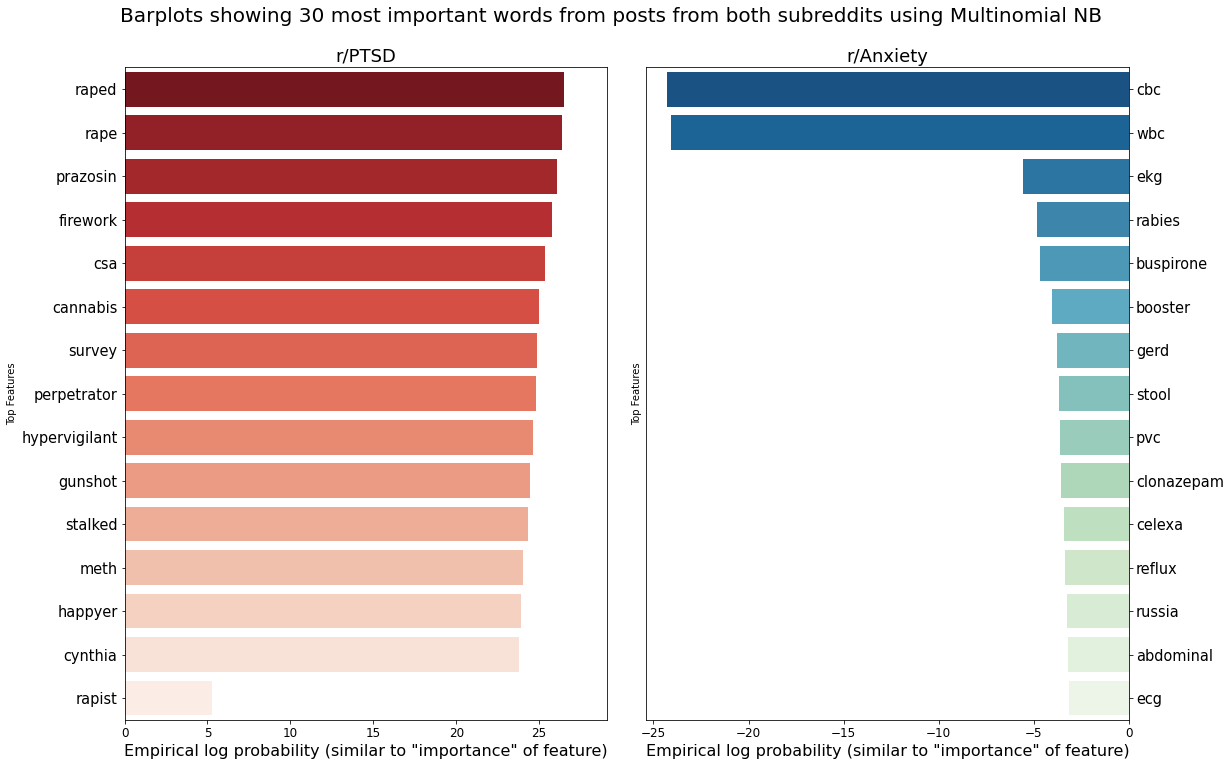

In [48]:
# Plotting barplots to visualise the most important features (tokens) along with their probabilities ("importance").

fig, ax = plt.subplots(figsize=(18,12), ncols=2)

# Reducing space between the two subplots.
plt.subplots_adjust(wspace=0.08)

ax = ax.ravel()

pal1 = sns.color_palette("Reds", len(df_plot_multi_top['Top Features']))
pal2 = sns.color_palette("GnBu", len(df_plot_multi_top['Top Features']))

# Plotting horizontal barplots.
sns.barplot(orient='h', y='Top Features', x='Log Probability Difference', ax=ax[0], palette=np.array(pal1[::-1]), data = df_plot_multi_top)
sns.barplot(orient='h', y='Top Features', x='Log Probability Difference', ax=ax[1], palette=np.array(pal2[::-1]), data = df_plot_multi)

# Setting the x-axis limits to be the same on both subplots.
ax[0].set(xlim=(0, round(df_plot_multi_top['Log Probability Difference'][0]*1.1, 3)))
ax[1].set(xlim=(0, round(df_plot_multi['Log Probability Difference'][0]*8, 3)))

# Inverting the x-axis and moving the y-axis labels to the right for subplot on the right.
ax[1].invert_xaxis()
ax[1].yaxis.tick_right()

# Setting the size of axis ticks.
ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=14.5)
ax[1].tick_params(axis='y', labelsize=14.5)


ax[0].set_xlabel("Empirical log probability (similar to \"importance\" of feature)", fontsize=16)
ax[1].set_xlabel("Empirical log probability (similar to \"importance\" of feature)", fontsize=16)

ax[0].set_title('r/PTSD', fontsize=18)
ax[1].set_title('r/Anxiety', fontsize=18)

fig.suptitle(x=0.5, y=0.95, t="Barplots showing 30 most important words from posts from both subreddits using Multinomial NB", fontsize=20);

# Exporting plot image in PNG format.
plt.savefig('../Photos/MultinomialNB_Features.png', bbox_inches='tight');

In [49]:
df.loc[df['selftext'].str.contains('firework'), 'selftext'][0:5]

47                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Users are talking about actual fireworks, expressing agony and how they are reacting to the load noises.

In [50]:
df[df['lemmi_clean_text'].str.contains('firework')].groupby(['month','user_contribute_where']).count()[['author']]

,,author
month,user_contribute_where,
1,ptsd_only,7
2,ptsd_only,3
5,ptsd_only,1
6,ptsd_only,7
7,ptsd_only,33
8,ptsd_only,5
9,ptsd_only,4
10,ptsd_only,3
11,ptsd_only,5


Highest number of post coming from July

***Firework Identified***

Found Fireworks seem to be interesting, upon investigating main dataset, the word mainly coming from the text and the title as well, explaining they have triggers likely due to firework loud noises. `In fact, all posts in the main dataset are coming from users in r/PTSD`.

The fact that it was highlighted as a main feature, suggest that it might be severe more with users from r/PTSD. True enough, based on ([*source*](https://www.insider.com/how-fireworks-affect-you-from-increased-anxiety-and-memory-problems-2020-7#:~:text=Repetitive%20fireworks%20launched%20at%20night,can%20weaken%20your%20immune%20system.)), people with `past trauma related to sound are impacted significantly worse by loud explosion` of fireworks, causing `reminiscent of threat` and may have activated the brain's threat detector. 

Linking back to the EDA on post, we did see spikes on `July 2021`.Based on ([*source*](https://wgntv.com/news/fireworks-retailer-warns-of-july-4-shortage-here-are-the-states-where-its-legal-to-stock-up/)), there is seasonal fireworks on `every 4th of July` across many states in the US. Although we cant assume most users from the subreddits are from US, but it is room for exploration, to deep dive into the location and firework activities. 



**For Bottom Features of Multinomial NB**

Words such as `CBC - Complete Blood Count`, `wbc - White blood cells` and `ekg` have the most predictive power to skew predictions towards r/Anxiety.

This indicates that most people having Anxiety will go for treatments and medications and often check for vital signs such as `cbc` and `wbc`. Based on ([*source*](https://pubmed.ncbi.nlm.nih.gov/28697416/)), people with anxiety tend to have increase `WBC` after measuring and evaluated their `CBC`. 

#### Logistic Regression

In [51]:
# Set up dataframe to get coefficients and feature names
df_logreg = pd.DataFrame([[x,y] for x,y in zip(gs_pipe2.best_estimator_[0].get_feature_names_out(), (gs_pipe2.best_estimator_[1].coef_).tolist()[0])])
df_logreg.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)

# Creating top few features 
df_plot_logreg_top = pd.DataFrame(
        {
        'Coefficients': df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)['Coefficients'].tolist(),
        'Top Features': df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)['Features'].tolist()
})

# Creating bottom few features
index = df_logreg.sort_values(by = 'Coefficients', ascending = False).tail(15)['Features'].tolist()
coef = df_logreg.sort_values(by = 'Coefficients', ascending = False).tail(15)['Coefficients'].tolist()

df_plot_logreg = pd.DataFrame({'Coefficients': coef,'Top Features': index}).sort_values(by = 'Coefficients', ascending = True)


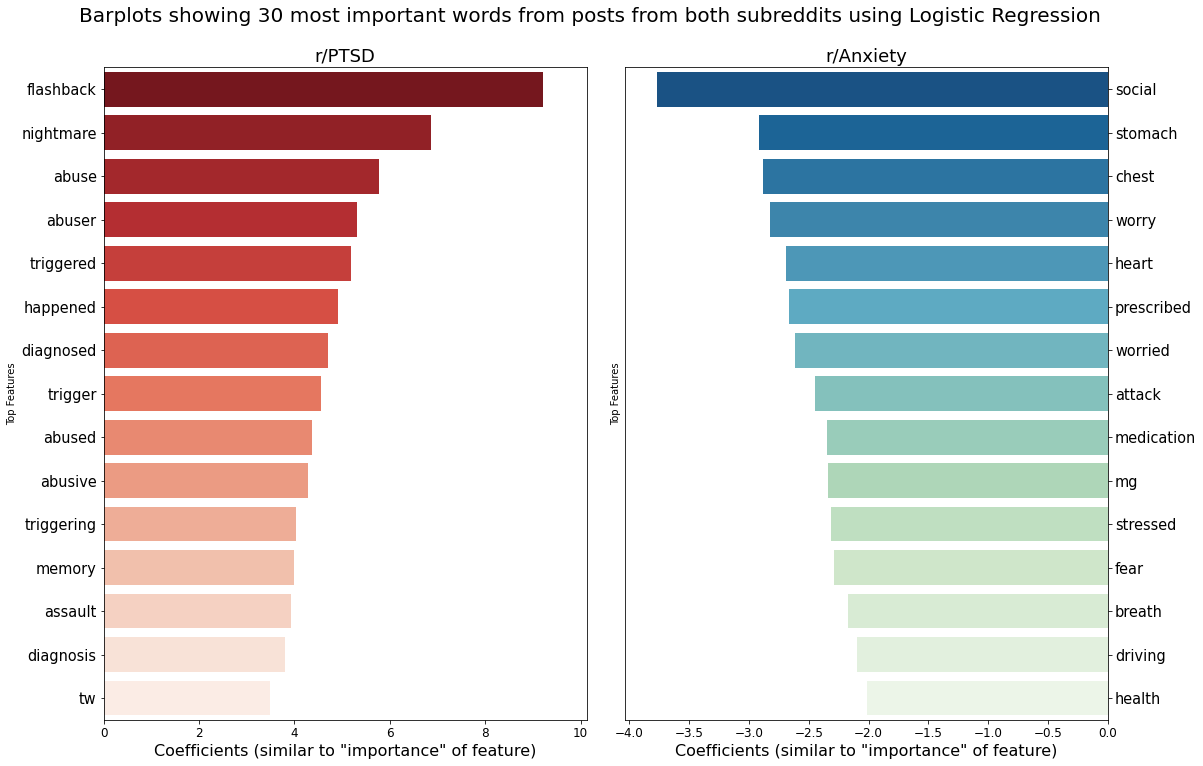

In [52]:
# Plotting barplots to visualise the most important features (tokens) along with their probabilities ("importance").

fig, ax = plt.subplots(figsize=(18,12), ncols=2);

# Reducing space between the two subplots.
plt.subplots_adjust(wspace=0.08);

ax = ax.ravel();

pal1 = sns.color_palette("Reds", len(df_plot_multi_top['Top Features']));
pal2 = sns.color_palette("GnBu", len(df_plot_multi_top['Top Features']));

# Plotting horizontal barplots.
sns.barplot(orient='h', y='Top Features', x='Coefficients', ax=ax[0], palette=np.array(pal1[::-1]), data = df_plot_logreg_top);
sns.barplot(orient='h', y='Top Features', x='Coefficients', ax=ax[1], palette=np.array(pal2[::-1]), data = df_plot_logreg);

# Setting the x-axis limits to be the same on both subplots.
ax[0].set(xlim=(0, round(df_plot_logreg_top['Coefficients'][0]*1.1, 3)));
ax[1].set(xlim=(0, round(df_plot_logreg['Coefficients'][0]*2, 3)));

# Inverting the x-axis and moving the y-axis labels to the right for subplot on the right.
ax[1].invert_xaxis();
ax[1].yaxis.tick_right();

# Setting the size of axis ticks.
ax[0].tick_params(axis='x', labelsize=12);
ax[1].tick_params(axis='x', labelsize=12);
ax[0].tick_params(axis='y', labelsize=14.5);
ax[1].tick_params(axis='y', labelsize=14.5);


ax[0].set_xlabel("Coefficients (similar to \"importance\" of feature)", fontsize=16);
ax[1].set_xlabel("Coefficients (similar to \"importance\" of feature)", fontsize=16);

ax[0].set_title('r/PTSD', fontsize=18);
ax[1].set_title('r/Anxiety', fontsize=18);

fig.suptitle(x=0.5, y=0.95, t="Barplots showing 30 most important words from posts from both subreddits using Logistic Regression", fontsize=20);

# Exporting plot image in PNG format.
plt.savefig('../Photos/Log_reg_features.png', bbox_inches='tight');

Words like `social`, `worry`, `fear`, are most commonly used to identify as users from r/Anxiety. I feel that `social` came about strongest in predicting users into r/Anxiety is because it is normally tagged with `social anxiety`

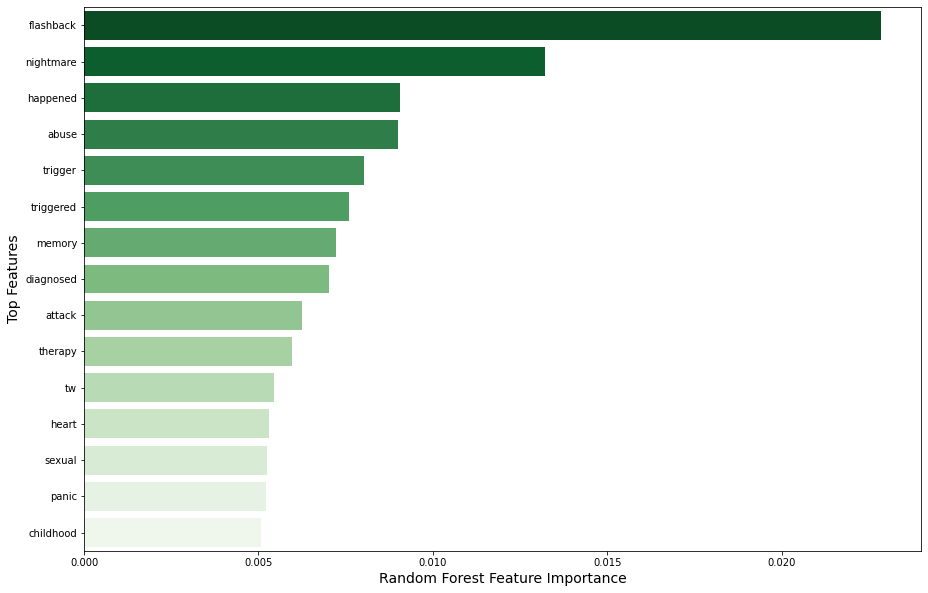

<Figure size 432x288 with 0 Axes>

In [53]:
forest_feat_importance = pd.DataFrame(gs_pipe5.best_estimator_[1].feature_importances_, index = gs_pipe5.best_estimator_[0].get_feature_names_out()).sort_values(by = 0, ascending = False).head(15)
forest_feat_importance.columns = ['mean_decrease_impurity']

forest_feat_importance = forest_feat_importance.reset_index()
forest_feat_importance.columns = ['Features', 'mean_decrease_impurity']


df_plot_forest_top = pd.DataFrame(
        {
        'Mean Decrease Impurity': forest_feat_importance['mean_decrease_impurity'].tolist(),
        'Top Features': forest_feat_importance['Features'].tolist()
})

# Set figure size 
plt.subplots(figsize=(15, 10))

# Setting up color pallete
pal = sns.color_palette("Greens", len(df_plot_forest_top['Top Features']))

# Plot seaborn barplot
sns.barplot(x='Mean Decrease Impurity', y='Top Features', palette=np.array(pal[::-1]), data = df_plot_forest_top)

plt.xlabel('Random Forest Feature Importance', fontdict={'fontsize': 14})
plt.ylabel('Top Features', fontdict={'fontsize': 14})

# Show plot
plt.show()

# Exporting plot image in PNG format.
plt.savefig('../Photos/Random_Forest_Features1.png', bbox_inches='tight');

**Comments on top few features**
- For logistic regression model, the top few features like 'flashbacks', 'nightmares', 'triggers' can serve as ***true symptoms of users suffering from PTSD***. Based on ([*source*](https://www.psychologytoday.com/us/conditions/post-traumatic-stress-disorder)), patients suffering from PTSD then to have those stated features. 

- Although it contains some words like 'abuse' that might describe ***causes of PTSD***, I believe when looking at the top few features from MultinomialNB, I can find more words that describes the ***causes AND triggers of PTSD*** more like 'rape', 'firework', 'gunshot', 'csa' which stands for childhood sexual abuse, 'repressed', 'stalked'.

- RandomForest has similar features ranked the same way as the Logistic Regression.  

- Overall by far, aligned with the accuracy score, I would conclude that MultinomialNB is more superior in getting defining words that may classifiy people with PTSD more. 

### Confusion matrix

Keeping in mind of minimising False negatives to boost sensitivity, we will use only MultinomialNB with the best params attained above for further error analysis 

We will look at the following 
1) ``False Negatives``
2) `False Positive`

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


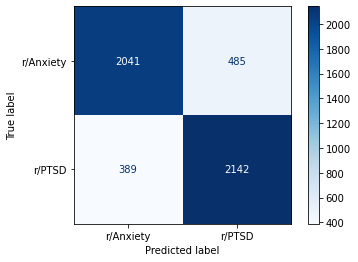

In [54]:
# Generate predictions.
preds = gs_pipe3.predict(X_test)

# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

# Plot Confusion matrix
plot_confusion_matrix(gs_pipe3, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['r/Anxiety', 'r/PTSD']);                 

There are total of 389 post misclassified to be false negative while 485 post are misclassified to be false positive

There are more post misclassified for predicting falsely for positive class (r/PTSD) when its actually negative (r/Anxiety). Hence more False positives than False negatives. 

### Analysis of Misclassified Posts

We will be looking deep into post created by users who post both in r/PTSD and r/Anxiety

Hence we first need to classify the error_df which contains all misclassifications, and then zoom into (user_contribute_where = `both`) and do some analysis

In [55]:
# create a dataframe to contain the posts, actual reddit and predicted reddit

y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['y'] = y_test.values
y_test_pred_df['y_pred'] = preds
y_test_pred_df = y_test_pred_df.merge(df.reset_index(), on = 'index')

y_test_pred_df = y_test_pred_df[['author','index','y','y_pred','title','selftext','lemmi_clean_text','month','user_contribute_where']]

In [56]:
error_df = y_test_pred_df[((y_test_pred_df['y'] == 1) & (y_test_pred_df['y_pred'] == 0)) | ((y_test_pred_df['y'] == 0) & (y_test_pred_df['y_pred'] == 1))]

#### Analysing False negatives (`y_pred == 0`, `y == 1`)

In [57]:
error_df.loc[error_df['index'] == 8720, ['index','y','y_pred','selftext','lemmi_clean_text','user_contribute_where']]

,index,y,y_pred,selftext,lemmi_clean_text,user_contribute_where
305,8720,1,0,"Does anyone else here struggle with nausea,headaches,stomach pain and so on?\nRight now im having a horrible day and im so nauseated and off that I cant do anything",anyone else struggle nausea headache stomach pain right horrible day nauseated cannot anything physical symptom,ptsd_only


In [58]:
# tokenize and place into df
test = pd.DataFrame(error_df.loc[error_df['index'] == 8720, 'lemmi_clean_text'].apply(word_tokenize).sum())
test.columns = ['Feature']

test['log_prob_diff'] = test['Feature'].apply(lambda x: df_multinomial[df_multinomial['Features'].str.contains(x)]['log_prob_diff'].values[0] if x in df_multinomial['Features'].tolist() else 0)
print(f'Overall sentiment is negative: {test.log_prob_diff.sum()}')
test.sort_values(by = 'log_prob_diff', ascending = True)

Overall sentiment is negative: -5.526048319285931


,Feature,log_prob_diff
5,stomach,-1.721603
3,nausea,-1.636253
4,headache,-1.330447
6,pain,-0.401737
7,right,-0.297280
15,symptom,-0.241308
14,physical,-0.220513
1,else,-0.209200
13,anything,-0.054331
0,anyone,0.000000


Although belonging to r/PTSD, this example did only mention about the side effects like `stomach` which happens to be the bottom feature of Logistic Regression, leaning towards predicting r/Anxiety.
For this particular case, the post did not exhibit strong predictive words that can help skew results 

#### Analysing False Positives (`y_pred == 1`, `y == 0`)

In [59]:
error_df[(error_df['y_pred'] ==1) & error_df['lemmi_clean_text'].str.contains('abuser')]

,author,index,y,y_pred,title,selftext,lemmi_clean_text,month,user_contribute_where
2558,Dramatic-Housing-471,10311,0,1,My dad says me having anxiety makes me a “p*ssy” and “not a real man”,"He also has anxiety and it destroyed his life, but he’s projecting onto me after I (M20) developed a panic disorder last year. When he found out how bad it actually was, I thought he would be nice. But he yelled at me and said some horrible things that honestly might put me into a depression for a while. \n\nHe said anxiety is a choice and that since my brain is like plastic, I can choose not to be anxious. And he said I’m gonna be a failure in life if I keep having panic attacks. And he even said he will shove as many triggers in my face whenever possible so I can “get the fuck over it”. \n\nHe also told he “I wish someone beat the shit out of you right now. Maybe that would teach you a lesson on manliness.” He also said I’m a disgrace to anyone who went through any actual PTSD trauma like marines or veterans.\n\nI told him he’s verbally abusing me and he said “I’m telling you this because I love you and want to see you succeed in life! The real world is rougher than I am and I’m trying to prepare you for it! And if this is abusive then I guess every military Sargent out there is an abuser! Haha! See! You can’t refute that! You loose!”\n\nCan I please have some support?",also destroyed life projecting onto developed panic last year found bad actually thought would nice yelled said horrible thing honestly might put depression said choice since brain like plastic choose said going failure life keep panic attack even said shove many trigger face whenever possible get fuck also told wish someone beat shit right maybe would teach lesson manliness also said disgrace anyone went actual like marine veteran told verbally abusing said telling love want see succeed life real world rougher trying prepare abusive guess every military sargent abuser haha see cannot refute loose please support dad say make p ssy real man,2,anxiety_only


In [60]:
# tokenize and place into df
test = pd.DataFrame(error_df.loc[error_df['index'] == 10311, 'lemmi_clean_text'].apply(word_tokenize).sum())
test.columns = ['Feature']

test['log_prob_diff'] = test['Feature'].apply(lambda x: df_multinomial[df_multinomial['Features'].str.contains(x)]['log_prob_diff'].values[0] if x in df_multinomial['Features'].tolist() else 0)
print(f'Overall log_prob_diff is positive towards r/PTSD: {test.log_prob_diff.sum()}')
test.sort_values(by = 'log_prob_diff', ascending = False)

Overall log_prob_diff is positive towards r/PTSD: 16.693634250561193


,Feature,log_prob_diff
88,abuser,5.154953
67,veteran,3.510666
83,abusive,2.362661
70,abusing,2.341268
86,military,2.284267
...,...,...
6,panic,-0.881756
32,failure,-0.892993
102,real,-0.949028
78,real,-0.949028


This post was misclassified as it contains alot of strong predictive words that was highlight from the Logistic Regression and MultinomialNB like `abuser`, `trigger` and `veteran`. The user was suffering from a dad who had PTSD. So, although user was from r/Anxiety, recalls of these moments speaking of about someone who has PTSD may actually lead to wrong prediction.  

#### Analyse misclassification from `Users using BOTH subreddits`

In [61]:
error_df[(error_df['user_contribute_where'] == 'both') & (error_df['selftext'].str.contains('social'))]

,author,index,y,y_pred,title,selftext,lemmi_clean_text,month,user_contribute_where
1292,yuugyho,4897,0,1,Am I a weak person? Honesty would be appreciated,"\nLong story short, I was abused a good chunk of my time in high school and it’s still bugging me to this day (I’m 24m). I was regularly abused by the same group of people but the main guy in the group was the one who would physically assault me whenever he got the chance and they were humiliating beat-up’s. This means that he was doing wrestling moves on me bc I was so small (he was absolutely massive for a 15 y/o kid), he’d literally hold me in the air with my feet facing the sky and slam me on my stomach while calling me the n word consistently throughout high school. He bullied me on social media as well. He’d always apologize after abusing me and I’d believe him then he’d beat me again and the cycle continued.\n\nHe reached out a while after high school to say he’s sorry but I already knew it was a selfish apology to make himself feel better. I accepted it but told him I’m not interested in started any type of friendship and told him to do him while I do me. He was very pleased by my response and wishing me well and all. I’ve entered insanity and can’t grasp the fact I have been abused, no one was listening to me when I tried to get help, and he’s all good now like nothing happened after all the suffering. Ive ditched my religion (which was my main source of being forgiving) and I have a heavy heart I’m feeling impulsive. Am I weak for always accepting his apologizes? Was I naive ? How can I be smarter ? I feel extremely insecure about these beatings, so much that I’ve moved to a different state and deleted all my social media so no one can contact me or see where I’m living.",long story short abused good chunk time high school still bugging day regularly abused group people main guy group one would physically assault whenever got chance humiliating beat-up mean wrestling move bc small absolutely massive kid would literally hold air foot facing sky slam stomach calling n word consistently throughout high school bullied social medium well would always apologize abusing would believe would beat cycle continued reached high school say sorry already knew selfish apology make feel better accepted told interested started type friendship told pleased response wishing well entered insanity cannot grasp fact abused one listening tried get help good like nothing happened suffering ditched religion main source forgiving heavy heart feeling impulsive weak always accepting apologizes naive smarter feel extremely insecure beating much moved different state deleted social medium one contact see living weak person honesty would appreciated,2,both
3646,sanpedro12,103,1,0,To Those Who Freeze Up In Social Settings: Have You Found A Way To Overcome It?,"\n\nHi there,\n\nMy social anxiety has been very bad lately. Everytime I have a social encounter, my whole body freezes up. I am so fucking nervous that I cant even speak a word. Especially my face muscles are very tense, which means that I cant laugh, smile, or express myself. When I try to talk, I stutter or stumble over my words which is so embarassing. I avoid eye contact because I feel my vis-a-vis recognizes that I am nervous and stares into my soul. Has anyone found a way to overcome this freezing response, be it medication or any other strategies?",hi social bad lately everytime social encounter whole body freeze fucking nervous cannot even speak word especially face muscle tense mean cannot laugh smile express try talk stutter stumble word embarassing avoid eye contact feel vis-a-vis recognizes nervous stare soul anyone found way overcome freezing response medication strategy freeze social setting found way overcome,1,both


In [62]:
# tokenize and place into df
test = pd.DataFrame(error_df.loc[error_df['index'] == 4897, 'lemmi_clean_text'].apply(word_tokenize).sum())
test.columns = ['Feature']

test['log_prob_diff'] = test['Feature'].apply(lambda x: df_multinomial[df_multinomial['Features'].str.contains(x)]['log_prob_diff'].values[0] if x in df_multinomial['Features'].tolist() else 0)
print(f'Overall log_prob_diff is positive towards r/PTSD: {test.log_prob_diff.sum()}')
test.sort_values(by = 'log_prob_diff', ascending = False).head(5)

Overall log_prob_diff is positive towards r/PTSD: 20.643189622869553


,Feature,log_prob_diff
22,assault,4.544007
3,abused,3.524986
95,abused,3.524986
13,abused,3.524986
59,abusing,2.341268


In [63]:
# tokenize and place into df
test = pd.DataFrame(error_df.loc[error_df['index'] == 103, 'lemmi_clean_text'].apply(word_tokenize).sum())
test.columns = ['Feature']

test['log_prob_diff'] = test['Feature'].apply(lambda x: df_multinomial[df_multinomial['Features'].str.contains(x)]['log_prob_diff'].values[0] if x in df_multinomial['Features'].tolist() else 0)
print(f'Overall log_prob_diff is positive towards r/PTSD: {test.log_prob_diff.sum()}')
test.sort_values(by = 'log_prob_diff', ascending = True).head(5)

Overall log_prob_diff is positive towards r/PTSD: 20.735853577790706


,Feature,log_prob_diff
29,stutter,-1.998762
1,social,-1.197056
5,social,-1.197056
51,social,-1.197056
39,nervous,-1.142605


Both sentiments, we read it, it would have predicted correctly into r/PTSD for the first row and into r/Anxiety for the second row. 
- The **First** row used words like `abused` and `assault` which strongly suggest user is coming from r/PTSD. But user posted on r/Anxiety. 
- The **Second** row used words like `social` which strongly correlates to `social anxiety` if it was calculated as a bigram. This user actually claims in `selftext`  that he has `social anxiety` and it strongly suggests user coming from r/Anxiety. But user posted on r/PTSD.

These are definitely misclassifications borne in users in the 'Both' category. These users are `ambiguous`, and we cannot account for the lack of indication whether or not these users belong to one truly. `Hence we need to remove them and retrain the model`


## Redefine Data set and run models

Remove users posting in both subreddits to remove potential misclassifications

We filter off users that are active in both subreddits and run two models with same settings in the hyper-parameter tuning
- `MultinomialNB`
- `Logistic Regression`

In [64]:
# how many rows deleted 
before = df.shape[0]
after = df[df['user_contribute_where']  != 'both'].shape[0]
print(f'Number of rows removed: {before - after}')
print(f'Percentage data removed: {round(((after - before) / before) * 100,2)}%')

Number of rows removed: 352
Percentage data removed: -1.74%


Only 1.74% of the data removed in order to exclude users who post on both subreddits.

### Reassign target variable
Filter off users with `both` under `user_contribute_where`

In [65]:
X_train_filtered = df[df['user_contribute_where']  != 'both']['lemmi_clean_text']
y_train_filtered = df[df['user_contribute_where']  != 'both']['subreddit']

### Train test and split new data

In [66]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_train_filtered, y_train_filtered, random_state=42, stratify=y_train_filtered)

### Re-train and Hyperparameter Tune models 

We are going to retrain existing models with newly `refined dataset`.
- `MultinomialNB`
- `Logistic Regression`

#### Multinomial regression with refined dataset

In [67]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe6 = Pipeline([('tfvec', TfidfVectorizer(stop_words= stopwordlist)),
                  ('nb', MultinomialNB())
                 ])
                 
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe6_params = {'tfvec__max_features': np.linspace(3700,3800,3, dtype = int),
                'tfvec__min_df': np.linspace(0,0.0001,5),
                'tfvec__max_df': np.linspace(0.20,0.3,5),
                'tfvec__ngram_range': [(1,1),(1,2)],
                'nb__alpha' : [1.0e-10],
}

# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe6 = GridSearchCV(pipe6, param_grid=pipe6_params, cv=5, n_jobs= -1)

# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe6.fit(X_train_filtered, y_train_filtered);

# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe6.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe6.score(X_train_filtered, y_train_filtered), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe6.score(X_test_filtered, y_test_filtered), 3)}")

# adding summary 

summary_df.loc[6] = [
    'Refined Dataset',
    'TfidfVec | MultinomialNB',
    str(gs_pipe6.best_params_),
    round(gs_pipe6.best_score_, 3),
    round(gs_pipe6.score(X_train_filtered, y_train_filtered), 3),
    round(gs_pipe6.score(X_test_filtered, y_test_filtered), 3)
]

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.834

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.858
Testing corpus accuracy = 0.834


#### Logistic regression with refined dataset

In [68]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: TfidfVectorizer 

pipe7 = Pipeline([
    ('tfvec7', TfidfVectorizer(stop_words= stopwordlist)),
    ('logreg7', LogisticRegression())
])

# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe7_params = {'tfvec7__max_features': np.linspace(8300,8400,5, dtype = int),
                'tfvec7__min_df': [0],
                'tfvec7__max_df':np.linspace(0.3,0.35,5),
                'tfvec7__ngram_range': [(1,1),(1,2)],
                'logreg7__max_iter': [1000]
}

# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and Logistic Regression with Hyper-parameter tuning

gs_pipe7 = GridSearchCV(pipe7, param_grid=pipe7_params, cv=5, n_jobs=-1)

# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe7.fit(X_train_filtered, y_train_filtered)

# Summary scores of CountVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe7.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe7.score(X_train_filtered, y_train_filtered), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe7.score(X_test_filtered, y_test_filtered), 3)}")


# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[7] = [
    'Refined DataSet',
    'TfidfVec | LogisticRegression',
    str(gs_pipe7.best_params_),
    round(gs_pipe7.best_score_, 3),
    round(gs_pipe7.score(X_train_filtered, y_train_filtered), 3),
    round(gs_pipe7.score(X_test_filtered, y_test_filtered), 3)
]

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.848

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.904
Testing corpus accuracy = 0.843


### Summary table Analysis

0.848	0.905	0.841

In [69]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.3, 'tfvec7__max_features': 8375, 'tfvec7__min_df': 0, 'tfvec7__ngram_range': (1, 2)}",0.848,0.904,0.843


## Production Model Selection

### Sensitivity of pipelines

In [70]:
# What is the test sensitivity of our model?
# By hand
list_of_gs = [gs_pipe1, gs_pipe2, gs_pipe3, gs_pipe4, gs_pipe5, gs_pipe6, gs_pipe7]


sensitivity_df = []
for gs in list_of_gs:
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    sensitivity_df.append(tp / (tp + fn))
    print(gs.best_estimator_[1],' = ',tp / (tp + fn))

sensitivity_df= pd.DataFrame(sensitivity_df)

LogisticRegression(max_iter=1000)  =  0.7538522323192414
LogisticRegression(max_iter=1000)  =  0.772026866851047
MultinomialNB(alpha=1e-10)  =  0.8463058079810352
LogisticRegression(max_iter=1000)  =  0.8150928486764125
RandomForestClassifier(max_features='sqrt', n_estimators=300)  =  0.7941525088897669
MultinomialNB(alpha=1e-10)  =  0.8640853417621494
LogisticRegression(max_iter=1000)  =  0.860924535756618


In [71]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.3, 'tfvec7__max_features': 8375, 'tfvec7__min_df': 0, 'tfvec7__ngram_range': (1, 2)}",0.848,0.904,0.843


In [72]:
summary_sensitivity = pd.merge(summary_df.reset_index(), sensitivity_df, left_index=True, right_index=True).drop(columns = 'index').rename(columns = {0:'Sensitivity'})
summary_sensitivity.sort_values(by = 'Sensitivity', ascending = False)

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity
5,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834,0.864085
6,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.3, 'tfvec7__max_features': 8375, 'tfvec7__min_df': 0, 'tfvec7__ngram_range': (1, 2)}",0.848,0.904,0.843,0.860925
2,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827,0.846306
3,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844,0.815093
4,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827,0.794153
1,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810,0.772027
0,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803,0.753852


### Specificity of Pipelines

In [73]:
# What is the test specificity of our model?
# By hand
list_of_gs = [gs_pipe1, gs_pipe2, gs_pipe3, gs_pipe4,gs_pipe5,gs_pipe6,gs_pipe7]


specificity_df = []
for gs in list_of_gs:
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    specificity_df.append(tn / (tn + fp))
    print(gs.best_estimator_[1],' = ',tn / (tn + fp))

specificity_df= pd.DataFrame(specificity_df)

LogisticRegression(max_iter=1000)  =  0.8531274742676168
LogisticRegression(max_iter=1000)  =  0.8479809976247031
MultinomialNB(alpha=1e-10)  =  0.8079968329374505
LogisticRegression(max_iter=1000)  =  0.8725257323832145
RandomForestClassifier(max_features='sqrt', n_estimators=300)  =  0.8598574821852731
MultinomialNB(alpha=1e-10)  =  0.8329374505146476
LogisticRegression(max_iter=1000)  =  0.9077593032462391


In [74]:
summary_sensitivity = pd.merge(summary_sensitivity.reset_index(), specificity_df, left_index=True, right_index=True).drop(columns = 'index').rename(columns = {0:'Specificity'})
summary_sensitivity.index = [1,2,3,4,5,6,7]
summary_sensitivity.sort_values(by = 'Sensitivity', ascending = False)

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity,Specificity
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834,0.864085,0.832937
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.3, 'tfvec7__max_features': 8375, 'tfvec7__min_df': 0, 'tfvec7__ngram_range': (1, 2)}",0.848,0.904,0.843,0.860925,0.907759
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827,0.846306,0.807997
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844,0.815093,0.872526
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827,0.794153,0.859857
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810,0.772027,0.847981
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803,0.753852,0.853127


Clearly, we will choose MultinomialNB as our production model as it has relative higher accuracy scores, with minimal overfit and very highest sensivity as compared to the rest of the models 

In [75]:
# What is the test specificity of our model?
# By hand
list_of_gs = [gs_pipe1, gs_pipe2, gs_pipe3, gs_pipe4,gs_pipe5,gs_pipe6,gs_pipe7]


roc_auc = []
for gs in list_of_gs:
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    roc_auc.append(roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
    print(gs.best_estimator_[1],' = ',roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))

roc_auc= pd.DataFrame(roc_auc)

LogisticRegression(max_iter=1000)  =  0.8833563574150838
LogisticRegression(max_iter=1000)  =  0.8924973245453918
MultinomialNB(alpha=1e-10)  =  0.9084892855120653
LogisticRegression(max_iter=1000)  =  0.9246663619729761
RandomForestClassifier(max_features='sqrt', n_estimators=300)  =  0.9051910701599454
MultinomialNB(alpha=1e-10)  =  0.9241165681730235
LogisticRegression(max_iter=1000)  =  0.9563249436207183


In [76]:
final_summary = pd.merge(summary_sensitivity.reset_index(), roc_auc, left_index=True, right_index=True).drop(columns = 'index').rename(columns = {0:'ROC_AUC'})
final_summary.index = [1,2,3,4,5,6,7]
final_summary.sort_values(by = 'ROC_AUC', ascending = False)

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity,Specificity,ROC_AUC
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.3, 'tfvec7__max_features': 8375, 'tfvec7__min_df': 0, 'tfvec7__ngram_range': (1, 2)}",0.848,0.904,0.843,0.860925,0.907759,0.956325
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844,0.815093,0.872526,0.924666
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834,0.864085,0.832937,0.924117
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827,0.846306,0.807997,0.908489
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827,0.794153,0.859857,0.905191
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810,0.772027,0.847981,0.892497
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803,0.753852,0.853127,0.883356


From baseline to refined data set remodelling, the average increase in accuracy is 5.8% from 0.801 to 0.848. The ROC_AUC however, increase larger by 9% from 0.88 to 0.95. 
Throught hyperparameter tuning and dataset refining, the current model in pipe7, using tfidVec and Logistic Regression renders the best model performance overall.

### Receiver Operating Characteristic (ROC) Curve

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


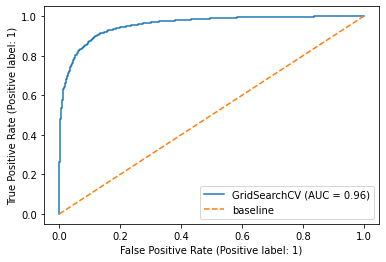

In [77]:
plot_roc_curve(gs_pipe7, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### Choice of Production Model

With specifity, sensitivity and ROC_AUC all tabularised with Accuracy score
- Logistic regression display excellent performance based on highest ROC_AUC score, giving good measure of separability with very minimal overlap. This better the model at distinguishing between patients with PTSD and without. 
- Althought the Logistic regression lose out by a margin in Sensitivity against Multinomial NB, its overall accuracy score and ROC_AUC is far more superior. 
- Random Forest should not be implemented as it needs huge amount of computational power and time. 

`Hence, Logistic regression is the chosen production model` 

Import Unseen Data from r/CPTSD

In [78]:
unseen_data = pd.read_csv('../Data/TEST_UNSEEN.csv')

In [79]:
unseen_data.drop(columns = 'Unnamed: 0', inplace = True)

Remove users who were in both 'r/PTSD' & 'r/Anxiety'

In [80]:
filter_out_users = df[df['user_contribute_where']  != 'both']['author'].unique().tolist()

In [81]:
unseen_data['filter'] = unseen_data['author'].apply(lambda x: 1 if x in filter_out_users else 0)

In [82]:
# split between users 
unseen_data['filter'].value_counts()

0    9586
1     434
Name: filter, dtype: int64

In [83]:
# using only those without the users inside 
test_data = unseen_data[unseen_data['filter'] == 0]

Generate predictions

In [84]:
PTSD_Anxiety = pd.DataFrame(gs_pipe7.predict(test_data['lemmi_clean_text']))

In [85]:
PTSD_Anxiety['have_ptsd'] = PTSD_Anxiety[0].apply(lambda x : 'PTSD' if x == 1 else 'Anxiety')

### Plot results for classifying 

Results should show more PTSD than Anxiety since we are taking post about C-PTSD (Complex - PTSD)

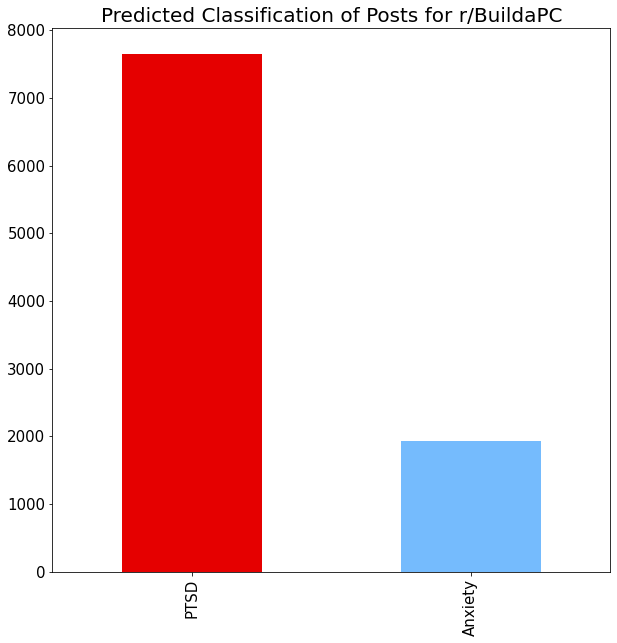

In [86]:
#plotting bar graph of AMD vs. Intel in r/BuildaPC
PTSD_Anxiety['have_ptsd'].value_counts().plot(kind='bar', color=['xkcd:red', 'xkcd:sky blue'], figsize = [10,10], fontsize = 15);

plt.title('Predicted Classification of Posts for r/BuildaPC', size=20);

Predictions are going the right way for a classifying a huge group of people who are in C-PTSD. 
We can start deploying in some social centers and allow time for them to collect more raw data and actual classifications based on medical advice. In the long run, the model should be improving over time given the proper combination of jargons used. 

## Conclusion and Recommendations


Beginning with the problem statement of accurately distinguishing potential people with PTSD apart from General Anxiety (subset), this project started with scraping 10000 subreddits post from each, r/PTSD and r/Anxiety, via the Reddit API. The posts were then undergone pre-processing and EDA followed by classificating modelling. 

Through EDA, I have highlighted on the signficant difference in subrreddict activity levels, where there were orginally 93 users who post in both subreddits suggesting that we may consider removing their post as they might bring ambiguity and inaccruacy as to whether users actually has PTSD or not. Users in r/PTSD generally do post longer text, with longer word count, and are not as active as compared to users fromr/Anxiety. In addition, we do observe there is cyclical trend, which suggest that there might be effects from SAD, that only affects people when there is lesser sunlight. Furthermore, through EDA on the common words, I did not find any distinguishing words that is able to differentiate subreddits if searched in the whole data set. But when split by subreddit groups, r/PTSD has `Therapy` singled out, unique for PTSD. It could imply users might need to go for therapy as often as compared to people with Anxiety. From r/Anxiety, common words like `panic` and `attack` are common symtoms from people having Anxiety. It is peculiar that users in r/PTSD do not experience this as a common effect. For bigrams and trigrams, `panic attack` were found in both subreddits and `sexual assault` were identified in r/PTSD as probably one of the common causes of users with PTSD. I did observe that `years ago` as top common words in bigram illustrating a long term time effect, suggesting it might take longer to overcome it as compared to r/Anxiety. 

After EDA, different classification models were built with Accuracy in mind. Random Forest took the longest computational time, hence would not recommend using this model for production. Furthermore the model tend to overfit with good score for training data but not for holdout. Will need a much more quicker model to generate fast output. During error analysis, found that there were the some of the 93 users who were in the wrong group and were classfied wrongly due to its content, but should have been true given its context and predictive power from the words used. To reduce this misclassfication, we will remove a total of 352 post out of 20000, rendering bearable to reduce 1.78% of the data to potentially reduce errors. After refining the dataset, the accuracy score improved by 1.2% for both models.

In [87]:
final_summary.sort_values(by = 'ROC_AUC', ascending= False)

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity,Specificity,ROC_AUC
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.3, 'tfvec7__max_features': 8375, 'tfvec7__min_df': 0, 'tfvec7__ngram_range': (1, 2)}",0.848,0.904,0.843,0.860925,0.907759,0.956325
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.22, 'tfvec4__max_features': 10000, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.896,0.844,0.815093,0.872526,0.924666
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834,0.864085,0.832937,0.924117
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3600, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827,0.846306,0.807997,0.908489
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.7, 'tfvec5__max_features': 7000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.824,1.000,0.827,0.794153,0.859857,0.905191
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810,0.772027,0.847981,0.892497
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803,0.753852,0.853127,0.883356


A final model - `Logistic Regression with tfidVectorizer` was picked for its incredible performance in ROC_AUC and overall Accuracy score. It's sensitivity score is relatively high too compared to MultinomialNB. Its accuracy is currently at 0.848 compared to its baseline score of 0.801, an overall increase of 5.8%.  The ROC_AUC however, increase larger by 9% from 0.88 to 0.95. Also, the value of accuracy can be seen when we trained the model on k-folds of crocss validation (estimated test set accuracy) was similar to the model test holdout data, by +- 5%. This implies that this classification model would `decently generalize well on new unseen data`

The ROC AUC value is at 0.96, an improvement from 0.88, implying that the `bag of tokens` from the positve class (r/PTSD) and the negative class (r/Anxiety) are separated almostly perfectly. 

Looking at the initial phase of modelling, referencing to MultinomialNB with the numbers of false postives and false negatives, it was seen to have alot of post from r/Anxiety got misclassified as positve. So it can be said that the classification model has a skewness towards the positive class (r/PTSD). One of the reason for this could be the fact that on average, much longer post in r/PTSD (as seen in the EDA process) - 1146 length of text as compared to 856 for r/Anxiety. This means in general, the documents from r/PTSD contributed more tokens to the model as compared to documents from r/Anxiety, thus slightly skewing towards r/PTSD. Another reason could be that r/PTSD shares similar symtoms to those suffering from Anxiety, hence if there is no strong predictive features existing in the document, it might be classified wrongly too. 

Answering the problem statement, indeed with the Logistic Regression model, the optimised ROC_AUC and sensitivity is able to reduce misclassification from, ie. for every 5057 people examined, a reduction of 994 people to 585 were misclassified. Specifically we focus on maximising sensitivity by reducing false negatives, from 623 to 352 people for every 5057 people are falsely classified negative (r/Anxiety) instead of being truely postive (r/PTSD). This feature, if implemented in the business process of social centers like entry forums for new patients having difficulty with Anxiety related disorder, will provide a **more automated guide to identify new patients who might sufferfrom PTSD so that we can quickly refer him/her to the neccessary treatment facility**. In this case, because there are **still a considerable number of overlaps**, it would be good to be used as a **trial first**, slowly beefing up **data feed into the model for better predicting accuracy and sensitivity**. This would however, **be a good platform as a quick guide for social workers to look out for pertinent signs that has been highlighted in the feature importance**. I believe if the model has been used more in the real world context, it should one day be more and more accurate. 